<a href="https://colab.research.google.com/github/nthtrung19/CNN_MNIST/blob/main/LeNet_CNN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Download datasets



In [1]:
#import libs
import os
import random
import numpy
import time

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from torchsummary import summary

import matplotlib.pyplot as plt
from PIL import Image

ROOT = './data'
train_data = datasets.MNIST(
    root=ROOT,
    train=True,
    download=True
)
test_data = datasets.MNIST(
    root=ROOT,
    train=False,
    download=True
)

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.59MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 135kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.28MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.90MB/s]


2. Preprocessing
- Chia ti le cac tap training : validation = 0.9 : 0.1
- Chuan hoa du lieu va chuyen sang tensor su dung torchvision.transform

In [2]:
#split training : validation = 0.9 : 0.1
TRAIN_RATIO = 0.9

n_train_examples = int(len(train_data) * TRAIN_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(
    train_data,
    [n_train_examples, n_valid_examples]
)

#compute mean and std for normalization
mean = train_data.dataset.data.float().mean() / 255
std = train_data.dataset.data.float().std() / 255

train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean], std=[std])
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean], std=[std])
])

train_data.dataset.transform = train_transforms
valid_data.dataset.transform = test_transforms

#create dataloader
BATCH_SIZE = 256

train_dataloader = data.DataLoader(
    train_data,
    shuffle=True,
    batch_size=BATCH_SIZE
)

valid_dataloader = data.DataLoader(
    valid_data,
    batch_size=BATCH_SIZE
)

3. Build LeNet Model

In [3]:
class LeNetClassifier(nn.Module):
  def __init__(self, num_classes):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding='same')
    self.avgpool1 = nn.AvgPool2d(kernel_size=2)
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
    self.avgpool2 = nn.AvgPool2d(kernel_size=2)
    self.flatten = nn.Flatten()
    self.fc_1 = nn.Linear(16 * 5 * 5, 120)
    self.fc_2 = nn.Linear(120, 84)
    self.fc_3 = nn.Linear(84, num_classes)

  def forward(self, inputs):
    outputs = self.conv1(inputs)
    outputs = self.avgpool1(outputs)
    outputs = F.relu(outputs)
    outputs = self.conv2(outputs)
    outputs = self.avgpool2(outputs)
    outputs = F.relu(outputs)
    outputs = self.flatten(outputs)
    outputs = self.fc_1(outputs)
    outputs = self.fc_2(outputs)
    outputs = self.fc_3(outputs)
    return outputs

4. Train model




In [4]:
# Training function
def train(model, optimizer, criterion, train_dataloader, device, epoch=0, log_interval=50):
    model.train()
    total_acc, total_count = 0, 0
    losses = []
    start_time = time.time()

    for idx, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        predictions = model(inputs)
        loss = criterion(predictions, labels)
        losses.append(loss.item())

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()

        total_acc += (predictions.argmax(1) == labels).sum().item()
        total_count += labels.size(0)

        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print(
                "| epoch {:3d} | {:5d}/{:5d} batches | accuracy {:8.3f}"
                .format(epoch, idx, len(train_dataloader), total_acc / total_count)
            )
            total_acc, total_count = 0, 0
            start_time = time.time()

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss


# Evaluation function (fixed)
def evaluate(model, criterion, valid_dataloader):
    model.eval()
    total_acc, total_count = 0, 0
    losses = []

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            predictions = model(inputs)
            loss = criterion(predictions, labels)
            losses.append(loss.item())

            total_acc += (predictions.argmax(1) == labels).sum().item()
            total_count += labels.size(0)

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss


- Training

In [6]:
num_classes = len(train_data.dataset.classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

lenet_model = LeNetClassifier(num_classes)
lenet_model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(lenet_model.parameters())

num_epochs = 10
save_model = './model'

train_accs, train_losses = [], []
eval_accs, eval_losses = [], []
best_loss_eval = 100

for epoch in range(1, num_epochs + 1):
  epoch_start_time = time.time()
  #Training
  train_acc, train_loss = train(lenet_model, optimizer, criterion, train_dataloader, device, epoch)
  train_accs.append(train_acc)
  train_losses.append(train_loss)

  #Evaluation
  eval_acc, eval_loss = evaluate(lenet_model, criterion, valid_dataloader)
  eval_accs.append(eval_acc)
  eval_losses.append(eval_loss)

  #Save best model
  if eval_loss < best_loss_eval:
    torch.save(lenet_model.state_dict(), save_model + '/lenet_model.pt')

  # Print loss, acc at end of epoch
  print("-" * 80)
  print(
      "| End of epoch {:3d} | Time: {:5.2f}s | "
      "Train Acc: {:8.3f} | Train Loss: {:8.3f} | "
      "Valid Acc: {:8.3f} | Valid Loss: {:8.3f}".format(
          epoch,
          time.time() - epoch_start_time,
          train_acc,
          train_loss,
          eval_acc,
          eval_loss
      )
  )
  print("-" * 80)

  #Load best model
  lenet_model.load_state_dict(torch.load(save_model + '/lenet_model.pt'))
  lenet_model.eval()


| epoch   1 |    50/  211 batches | accuracy    0.690
| epoch   1 |   100/  211 batches | accuracy    0.886
| epoch   1 |   150/  211 batches | accuracy    0.915
| epoch   1 |   200/  211 batches | accuracy    0.935
--------------------------------------------------------------------------------
| End of epoch   1 | Time: 12.47s | Train Acc:    0.945 | Train Loss:    0.498 | Valid Acc:    0.951 | Valid Loss:    0.165
--------------------------------------------------------------------------------
| epoch   2 |    50/  211 batches | accuracy    0.955
| epoch   2 |   100/  211 batches | accuracy    0.961
| epoch   2 |   150/  211 batches | accuracy    0.965
| epoch   2 |   200/  211 batches | accuracy    0.967
--------------------------------------------------------------------------------
| End of epoch   2 | Time: 12.29s | Train Acc:    0.973 | Train Loss:    0.122 | Valid Acc:    0.968 | Valid Loss:    0.110
-----------------------------------------------------------------------------

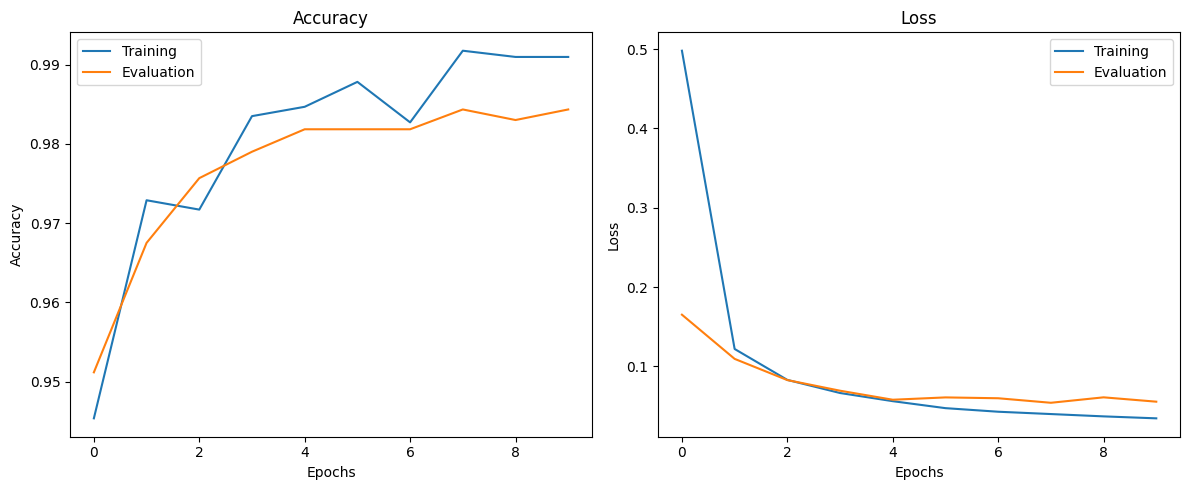

In [8]:
# train_accs = [accuracy của từng epoch trên train]
# eval_accs = [accuracy trên tập validation]
# train_losses = [loss từng epoch trên train]
# eval_losses = [loss trên validation]

epochs = range(len(train_accs))  # hoặc range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# ---- ACCURACY subplot ----
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accs, label='Training')
plt.plot(epochs, eval_accs, label='Evaluation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()

# ---- LOSS subplot ----
plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses, label='Training')
plt.plot(epochs, eval_losses, label='Evaluation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [9]:
test_data.transform = test_transforms
test_dataloader = data.DataLoader(
    test_data,
    batch_size=BATCH_SIZE
)
test_acc, test_loss = evaluate(lenet_model, criterion, test_dataloader)
test_acc, test_loss

(0.9863, 0.04036255186765629)